<img src="title.png">

In [100]:
import pandas as pd
import numpy as np
from collections import Counter as count
import matplotlib.pyplot as plt
import forgi.graph.bulge_graph as fgb
import forgi.visual.mplotlib as fvm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import MaxNLocator

In [2]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
sub = pd.read_csv('sample_submission.csv')

In [3]:
print('Train shapes: ', train.shape)
print('Test shapes: ', test.shape)

Train shapes:  (2400, 19)
Test shapes:  (3634, 7)


# Cargando los datos

In [4]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
sub

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.0,0.0,0.0,0.0,0.0
457949,id_ffda94f24_126,0.0,0.0,0.0,0.0,0.0
457950,id_ffda94f24_127,0.0,0.0,0.0,0.0,0.0
457951,id_ffda94f24_128,0.0,0.0,0.0,0.0,0.0


# Analisis exploratorio de datos

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [7]:
train.describe()

,index,signal_to_noise,SN_filter,seq_length,seq_scored
count,2400.000000,2400.000000,2400.000000,2400.0,2400.0
mean,1199.500000,4.530456,0.662083,107.0,68.0
std,692.964646,2.835142,0.473099,0.0,0.0
min,0.000000,-0.103000,0.000000,107.0,68.0
25%,599.750000,2.391000,0.000000,107.0,68.0
50%,1199.500000,4.442500,1.000000,107.0,68.0
75%,1799.250000,6.294250,1.000000,107.0,68.0
max,2399.000000,17.194000,1.000000,107.0,68.0


## Columnas Entrada
- **id** - An arbitrary identifier for each sample.
- **seq_scored** - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
- **seq_length** - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
- **sequence** - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).
- **structure** - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

- **predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

## Variables Objetivo
- **reactivity** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.
- **deg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
- **deg_Mg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
- **deg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
- **deg_Mg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

Columnas que representan la estructura de la secuencia:
- sequence
- structure
- predicted_loop_type

### Analizando Sequence

Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

Para el RNA tenemos 4 posibles bases nitrogenadas:
1) Guanine (G)
2) Adenine (A)
3) Cytosine (C)
4) Uracil (U)

In [8]:
train.sequence

0       GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
1       GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...
2       GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...
3       GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...
4       GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...
                              ...                        
2395    GGAAAAUAGCAGAGGAAAUACUAGAGCAAUUGCAAAGGCCGAUCAU...
2396    GGAAAACAAAAACAAACAACAAAAACAAACAACAAAAACAAACAAC...
2397    GGAAAGCCAUACCUAGGCUUCGGCCUAGGUAUGGCGGUGAUCUGGU...
2398    GGAAACGAUAGCAGAAGAGAUCGAUAUAGAGCAUAAGCUAAGAAUA...
2399    GGAAAGCUAGGACGUGGGAGCGUAGCUCUCCACACGGGUACGCCAA...
Name: sequence, Length: 2400, dtype: object

Probando la primer secuencia

In [9]:
count(train['sequence'][0])

Counter({'G': 19, 'A': 45, 'C': 23, 'U': 20})

#### Validando el campo seq_length

In [10]:
train['seq_length'].describe()

count    2400.0
mean      107.0
std         0.0
min       107.0
25%       107.0
50%       107.0
75%       107.0
max       107.0
Name: seq_length, dtype: float64

Todas las secuencias tienen una longitud de 107

### Analizando structure

An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.


Explicacion : https://www.ebi.ac.uk/training/online/courses/biomacromolecular-structures/rna/

Most RNA molecules contain short self-complementary sequences that fold and pair with each other into highly structured forms. These base-pairing interactions are part of RNA secondary structure. The unpaired regions form structures such as hairpin loops, bulges and internal loops, which may be of functional importance (Figure 7). Examples include Rho-independent terminator stem-loops and the tRNA cloverleaf.

<img src="rna_structure.png">

In [11]:
def plot_sample(seq, struct):
    plt.figure(figsize=(10,6))
    bg = fgb.BulgeGraph.from_fasta_text(f'>rna1\n{struct}\n{seq}')[0]
    fvm.plot_rna(bg)
    plt.show()

In [12]:
train.structure

0       .....((((((.......)))).)).((.....((..((((((......
1       .....(((((((((((((((((((((((....)))))))))).)))...
2       .....((((.((.....((((.(((.....)))..((((......)...
3       ......((((((((((((((((......))))))))))))))))((...
4       .....(((((((.((((((((((((.(((((((((....)))))))...
                              ...                        
2395    ........((..((......))...)).........(((..........
2396    .................................................
2397    .....(((((((((((((....)))))))))))))(((((((((((...
2398    .....((((..(....)..))))......(((....)))..........
2399    .....((((((((((((((((...)))).)))).((((((((((.....
Name: structure, Length: 2400, dtype: object

In [13]:
count(train['structure'][0])

Counter({'.': 61, '(': 23, ')': 23})

In [14]:
print(train['sequence'][0])
print(train['structure'][0])

GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................


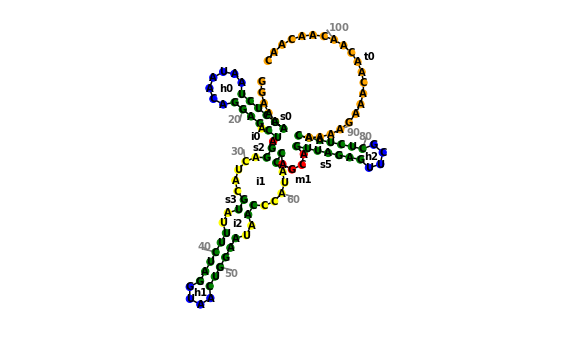

In [15]:
plot_sample(train['sequence'][0], train['structure'][0])

### Analizando predicted_loop_type
predicted_loop_type (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. 
From the bpRNA_documentation: 
- S: paired "Stem" 
- M: Multiloop 
- I: Internal loop 
- B: Bulge H: Hairpin loop 
- E: dangling End 
- X: eXternal loop

<img src="rna_loops.png">

In [16]:
print(train['sequence'][1])
print(train['structure'][1])
print(train['predicted_loop_type'][1])

GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACCGCGCGCGCUUAUGCAAGUUGCCCGCGGCGUUCGCGCUGUGAAAAGAAACAACAACAACAAC
.....(((((((((((((((((((((((....)))))))))).)))))))))))))..(((...))).(((((((....))))))).....................
EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSSSSSSSSSSSSMMSSSHHHSSSMSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE


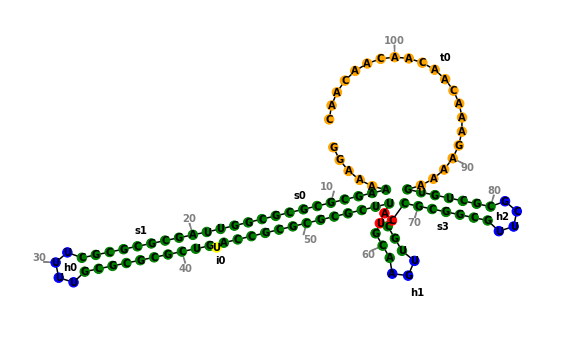

In [17]:
plot_sample(train['sequence'][1], train['structure'][1])

### Variables Objetivo

In [18]:
print(train['reactivity'][1])
print(train['deg_Mg_pH10'][1])
print(train['deg_pH10'][1])
print(train['deg_Mg_50C'][1])
print(train['deg_50C'][1])

[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0878, 0.0, -1.0334, 4.7697, 2.8911, 1.2158, 1.1483, 1.0878, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0334, 0.0, 0.9842000000000001, 0.0, 0.0, 0.0, 0.9395, -0.9395, 0.8986000000000001, 0.0, 0.0, 0.0, 0.8612000000000001, 0.8267, 0.795, 0.0, 1.4763, 0.7127, 0.6890000000000001, 0.0, 2.4316, 1.6758000000000002, 1.0599, 1.0082, 0.9613, 0.4697, -1.2631000000000001, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7758, 0.0, -0.737, 0.0, 14.0377, 0.0, 0.0, 0.0, 4.9134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.8962, 2.4568, 0.0, 0.0, 1.4358, 3.2757, 1.4741, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3401, 1.2284, 2.9482, 0.9213, 2.3275, 0.737, 1.3401, 0.6409, 3.4396, 0.47550000000000003, 0.4607, -0.7817000000000001, 0.0, 0.43360000000000004]
[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Creando el set de datos

In [19]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    for i in range(0,68):
        sample_tuple = (
            sample_data['id'].values[0],
            i+1,
            sample_data['sequence'].values[0][i],
            sample_data['structure'].values[0][i], 
            sample_data['predicted_loop_type'].values[0][i],
            sample_data['reactivity'].values[0][i], 
            sample_data['reactivity_error'].values[0][i],
            sample_data['deg_Mg_pH10'].values[0][i], 
            sample_data['deg_error_Mg_pH10'].values[0][i],
            sample_data['deg_pH10'].values[0][i], 
            sample_data['deg_error_pH10'].values[0][i],
            sample_data['deg_Mg_50C'].values[0][i], 
            sample_data['deg_error_Mg_50C'].values[0][i],
            sample_data['deg_50C'].values[0][i], 
            sample_data['deg_error_50C'].values[0][i]
        )
        train_data.append(sample_tuple)

In [20]:
train_data = pd.DataFrame(
    train_data, 
    columns=[
        'id', 'position','sequence', 'structure', 'predicted_loop_type', 
        'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10',
        'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 
        'deg_50C', 'deg_error_50C'
    ]
)

In [21]:
train_data.head()

,id,position,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
0,id_001f94081,1,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167
1,id_001f94081,2,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475
2,id_001f94081,3,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880
3,id_001f94081,4,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124
4,id_001f94081,5,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703


In [22]:
train_data.describe()

,position,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
count,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000,163200.000000
mean,34.500000,0.374922,2834.110981,0.446303,2332.815143,0.446911,6292.705603,0.407030,3582.263512,0.425889,5982.834519
std,19.627847,0.725652,19128.620088,0.704172,14627.228661,1.285747,42334.295746,0.868013,23237.578303,1.122356,38197.947633
min,1.000000,-20.664800,0.001900,-14.740500,0.006100,-44.515300,0.008300,-24.252500,0.004100,-38.339900,0.006500
25%,17.750000,0.043500,0.044900,0.131400,0.057200,0.099500,0.073900,0.074000,0.052000,0.092200,0.081400
50%,34.500000,0.215800,0.083000,0.289400,0.098900,0.275100,0.120600,0.255800,0.088900,0.307900,0.133800
75%,51.250000,0.539700,0.173000,0.567425,0.201200,0.568600,0.245100,0.560200,0.182500,0.613600,0.265700
max,68.000000,20.667500,146151.225000,14.740100,104235.174200,44.521200,314833.569500,24.254900,171525.321700,38.343800,271158.604000


## Reactivity

Text(0.5, 1.0, 'Uracil (U)')

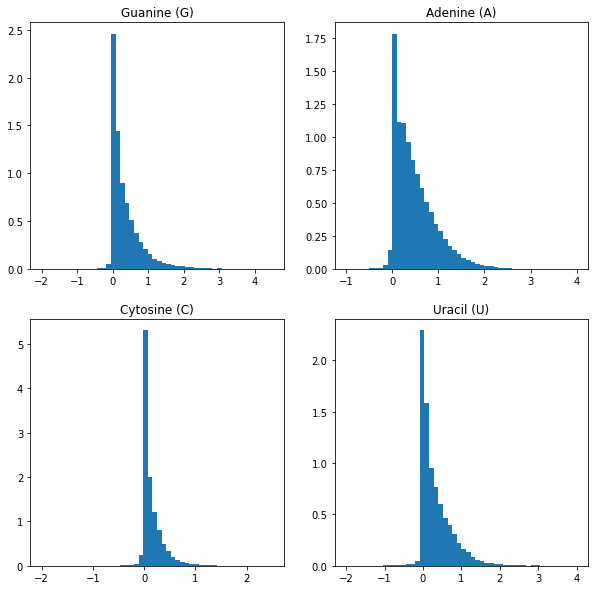

In [23]:
g_val = train_data[train_data.sequence == 'G']['reactivity'].values
a_val = train_data[train_data.sequence == 'A']['reactivity'].values
c_val = train_data[train_data.sequence == 'C']['reactivity'].values
u_val = train_data[train_data.sequence == 'U']['reactivity'].values

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(g_val, bins=50, density=True, range=(-2,4.5))
axs[0, 0].set_title('Guanine (G)')
axs[0, 1].hist(a_val, bins=50, density=True, range=(-1,4))
axs[0, 1].set_title('Adenine (A)')
axs[1, 0].hist(c_val, bins=50, density=True, range=(-2,2.5))
axs[1, 0].set_title('Cytosine (C)')
axs[1, 1].hist(u_val, bins=50, density=True, range=(-2,4))
axs[1, 1].set_title('Uracil (U)')

## deg_pH10

Text(0.5, 1.0, 'Uracil (U)')

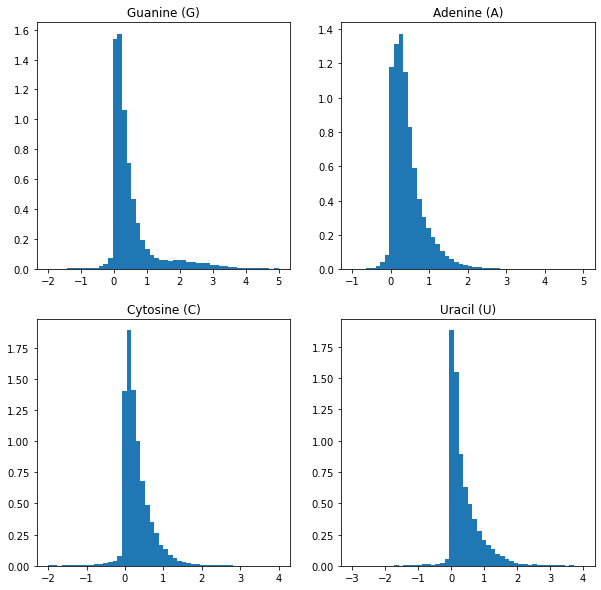

In [24]:
g_val = train_data[train_data.sequence == 'G']['deg_pH10'].values
a_val = train_data[train_data.sequence == 'A']['deg_pH10'].values
c_val = train_data[train_data.sequence == 'C']['deg_pH10'].values
u_val = train_data[train_data.sequence == 'U']['deg_pH10'].values

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(g_val, bins=50, density=True, range=(-2,5))
axs[0, 0].set_title('Guanine (G)')
axs[0, 1].hist(a_val, bins=50, density=True, range=(-1,5))
axs[0, 1].set_title('Adenine (A)')
axs[1, 0].hist(c_val, bins=50, density=True, range=(-2,4))
axs[1, 0].set_title('Cytosine (C)')
axs[1, 1].hist(u_val, bins=50, density=True, range=(-3,4))
axs[1, 1].set_title('Uracil (U)')


## deg_Mg_pH10

Text(0.5, 1.0, 'Uracil (U)')

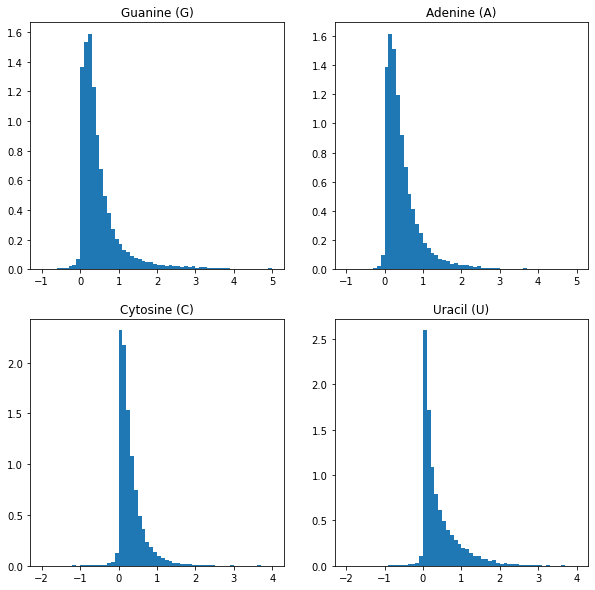

In [25]:
g_val = train_data[train_data.sequence == 'G']['deg_Mg_pH10'].values
a_val = train_data[train_data.sequence == 'A']['deg_Mg_pH10'].values
c_val = train_data[train_data.sequence == 'C']['deg_Mg_pH10'].values
u_val = train_data[train_data.sequence == 'U']['deg_Mg_pH10'].values

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(g_val, bins=60, density=True, range=(-1,5))
axs[0, 0].set_title('Guanine (G)')
axs[0, 1].hist(a_val, bins=60, density=True, range=(-1,5))
axs[0, 1].set_title('Adenine (A)')
axs[1, 0].hist(c_val, bins=60, density=True, range=(-2,4))
axs[1, 0].set_title('Cytosine (C)')
axs[1, 1].hist(u_val, bins=60, density=True, range=(-2,4))
axs[1, 1].set_title('Uracil (U)')


# MODELO BASE

In [26]:
seq = pd.get_dummies(train_data['sequence'], prefix='base')

In [27]:
seq.head()

,base_A,base_C,base_G,base_U
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [28]:
struc = pd.get_dummies(train_data['structure'], prefix='struc')

In [29]:
struc.head()

,struc_(,struc_),struc_.
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [30]:
x_train = pd.concat([seq, struc], axis=1)
x_train.head()

,base_A,base_C,base_G,base_U,struc_(,struc_),struc_.
0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,1
2,1,0,0,0,0,0,1
3,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1


In [31]:
y_train = train_data['reactivity']

## XGBoost

In [32]:
params = {
    'n_estimators': 700,
    'learning_rate': 0.5,
    'max_depth': 7,
    'alpha': 1,
    'eval_metric': 'rmse',
    'n_jobs': 4,
    'verbosity': 1
}
model = XGBRegressor(**params)

In [33]:
model.fit(
    x_train, y_train
)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [34]:
predictions = model.predict(x_train.to_numpy())
train_rmse = (mean_squared_error(y_train, predictions))**0.5
train_mae = mean_absolute_error(y_train, predictions)

/home/erick/anaconda3/envs/bioinformatic_python/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


## Errors
RMSE=$\sqrt{\frac{\sum_{i=1}^{D}(x_i-y_i)^2}{N}}$ 

MAE=$\sum_{i=1}^{N}\frac{|x_i-y_i|}{N}$

In [35]:
print(f"RMSE : {train_rmse} , MAE: {train_mae}")

RMSE : 0.6949832288571517 , MAE: 0.3018442559079913


In [36]:
tmp = train_data[['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity']].copy()
tmp['predicted_reactivity'] = predictions
tmp[tmp.id == 'id_001f94081']

,id,sequence,structure,predicted_loop_type,reactivity,predicted_reactivity
0,id_001f94081,G,.,E,0.3297,0.660938
1,id_001f94081,G,.,E,1.5693,0.660938
2,id_001f94081,A,.,E,1.1227,0.589409
3,id_001f94081,A,.,E,0.8686,0.589409
4,id_001f94081,A,.,E,0.7217,0.589409
...,...,...,...,...,...,...
63,id_001f94081,C,),S,0.0693,0.105422
64,id_001f94081,A,.,X,0.1398,0.589409
65,id_001f94081,G,.,X,0.2937,0.660938
66,id_001f94081,C,.,X,0.2362,0.279821


In [37]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


### Linear Model v2

In [38]:
train['base_counts'] = train.apply(
    lambda x: dict(count(x['sequence'])),
    axis=1
)

In [39]:
train['A_percentage'] = train.apply(
    lambda x: x['base_counts']['A']/ len(x['sequence']),
    axis=1                           
)
train['G_percentage'] = train.apply(
    lambda x: x['base_counts']['G']/ len(x['sequence']),
    axis=1                           
)
train['C_percentage'] = train.apply(
    lambda x: x['base_counts']['C']/ len(x['sequence']),
    axis=1                           
)
train['U_percentage'] = train.apply(
    lambda x: x['base_counts']['U']/ len(x['sequence']),
    axis=1                           
)

In [40]:
train.shape

(2400, 24)

In [41]:
train_data.shape

(163200, 15)

In [42]:
train_data = train_data.merge(
    train[['id', 'A_percentage', 'G_percentage', 'C_percentage', 'U_percentage']],
    on='id',
    how='left'
)

In [43]:
train_data

,id,position,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C,A_percentage,G_percentage,C_percentage,U_percentage
0,id_001f94081,1,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167,0.420561,0.177570,0.214953,0.186916
1,id_001f94081,2,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475,0.420561,0.177570,0.214953,0.186916
2,id_001f94081,3,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880,0.420561,0.177570,0.214953,0.186916
3,id_001f94081,4,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124,0.420561,0.177570,0.214953,0.186916
4,id_001f94081,5,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703,0.420561,0.177570,0.214953,0.186916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163195,id_fff546103,64,C,),S,0.0272,0.0267,0.5059,0.0626,0.4998,0.0996,0.2870,0.0638,0.1820,0.0809,0.317757,0.280374,0.271028,0.130841
163196,id_fff546103,65,U,),S,0.0382,0.0219,0.2025,0.0411,0.3057,0.0760,0.2022,0.0520,0.2038,0.0748,0.317757,0.280374,0.271028,0.130841
163197,id_fff546103,66,A,),S,0.0381,0.0218,0.1827,0.0391,0.1642,0.0611,0.2047,0.0520,0.1120,0.0612,0.317757,0.280374,0.271028,0.130841
163198,id_fff546103,67,G,),S,-0.0066,0.0220,0.3261,0.0509,0.1654,0.0719,0.2447,0.0595,0.1186,0.0723,0.317757,0.280374,0.271028,0.130841


In [44]:
x_train = pd.concat(
    [x_train, train_data[['A_percentage', 'G_percentage', 'C_percentage', 'U_percentage']]],
    axis=1
)
x_train.head()

,base_A,base_C,base_G,base_U,struc_(,struc_),struc_.,A_percentage,G_percentage,C_percentage,U_percentage
0,0,0,1,0,0,0,1,0.420561,0.17757,0.214953,0.186916
1,0,0,1,0,0,0,1,0.420561,0.17757,0.214953,0.186916
2,1,0,0,0,0,0,1,0.420561,0.17757,0.214953,0.186916
3,1,0,0,0,0,0,1,0.420561,0.17757,0.214953,0.186916
4,1,0,0,0,0,0,1,0.420561,0.17757,0.214953,0.186916


In [45]:
params = {
    'n_estimators': 700,
    'learning_rate': 0.5,
    'max_depth': 7,
    'alpha': 1,
    'eval_metric': 'rmse',
    'n_jobs': 4,
    'verbosity': 1
}
model = XGBRegressor(**params)

In [46]:
model.fit(
    x_train, y_train
)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [47]:
predictions = model.predict(x_train.to_numpy())
train_rmse = (mean_squared_error(y_train, predictions))**0.5
train_mae = mean_absolute_error(y_train, predictions)

/home/erick/anaconda3/envs/bioinformatic_python/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


## Errors
RMSE=$\sqrt{\frac{\sum_{i=1}^{D}(x_i-y_i)^2}{N}}$ 

MAE=$\sum_{i=1}^{N}\frac{|x_i-y_i|}{N}$

In [48]:
print(f"RMSE : {train_rmse} , MAE: {train_mae}")

RMSE : 0.6467684193759288 , MAE: 0.26462017634514395


In [49]:
tmp = train_data[['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity']].copy()
tmp['predicted_reactivity'] = predictions
tmp[tmp.id == 'id_001f94081']

,id,sequence,structure,predicted_loop_type,reactivity,predicted_reactivity
0,id_001f94081,G,.,E,0.3297,0.689619
1,id_001f94081,G,.,E,1.5693,0.689619
2,id_001f94081,A,.,E,1.1227,0.712921
3,id_001f94081,A,.,E,0.8686,0.712921
4,id_001f94081,A,.,E,0.7217,0.712921
...,...,...,...,...,...,...
63,id_001f94081,C,),S,0.0693,0.146758
64,id_001f94081,A,.,X,0.1398,0.712921
65,id_001f94081,G,.,X,0.2937,0.689619
66,id_001f94081,C,.,X,0.2362,0.336933


Text(0.5, 1.0, 'Importancia de las Variables')

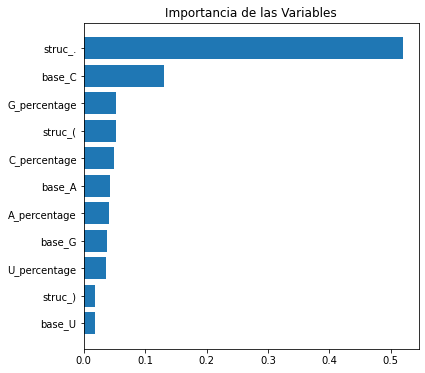

In [50]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Importancia de las Variables')

# Deep Learning Model

In [51]:
import tensorflow as tf
from tensorflow import keras

In [52]:
print(tf.__version__)
print(keras.__version__)

2.6.2
2.6.0


In [53]:
x_train.shape

(163200, 11)

## Funciones de activacion
Sigmoid:

$\sigma(z) = \frac{1} {1 + e^{-z}}$

Relu:

$Relu(z) = max(0, z)$

In [54]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11]),
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
____________________________________________________

In [56]:
y_train = train_data['reactivity']

In [57]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics="mean_squared_error")
hist = model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4965 - mean_squared_error: 0.4965
Epoch 2/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4925 - mean_squared_error: 0.4925
Epoch 3/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4912 - mean_squared_error: 0.4912
Epoch 4/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4894 - mean_squared_error: 0.4894
Epoch 5/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4894 - mean_squared_error: 0.4894
Epoch 6/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4885 - mean_squared_error: 0.4885
Epoch 7/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4869 - mean_squared_error: 0.4869
Epoch 8/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4862 - mean_squared_error: 0.4862
Epoch 9/10
2550/2550 [==============================] - 4s 2ms/step - loss: 0.4848 - mean_squared_error:

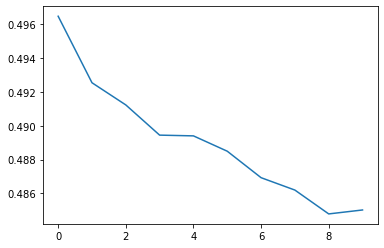

In [58]:
plt.plot(hist.history['mean_squared_error'])

### Multiples Salidas

In [65]:
y_train = train_data[['reactivity', 'deg_pH10', 'deg_Mg_pH10']]

In [66]:
seq = pd.get_dummies(train_data['sequence'], prefix='base')
struc = pd.get_dummies(train_data['structure'], prefix='struc')
loop = pd.get_dummies(train_data['predicted_loop_type'], prefix='loop')

In [67]:
x_train = pd.concat(
    [seq, struc, loop, train_data[['position','A_percentage', 'G_percentage', 'C_percentage', 'U_percentage']]],
    axis=1
)
x_train.head()

,base_A,base_C,base_G,base_U,struc_(,struc_),struc_.,loop_B,loop_E,loop_H,loop_I,loop_M,loop_S,loop_X,position,A_percentage,G_percentage,C_percentage,U_percentage
0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0.420561,0.17757,0.214953,0.186916
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,2,0.420561,0.17757,0.214953,0.186916
2,1,0,0,0,0,0,1,0,1,0,0,0,0,0,3,0.420561,0.17757,0.214953,0.186916
3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,4,0.420561,0.17757,0.214953,0.186916
4,1,0,0,0,0,0,1,0,1,0,0,0,0,0,5,0.420561,0.17757,0.214953,0.186916


In [68]:
x_train.shape

(163200, 19)

## Red Neuronal

In [69]:
def MCRMSE(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    return tf.reduce_mean(rmse)

In [72]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[19]),
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(3)
])

In [73]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=MCRMSE)
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8339 - MCRMSE: 0.6995
Epoch 2/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8241 - MCRMSE: 0.6896
Epoch 3/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8212 - MCRMSE: 0.6905
Epoch 4/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8183 - MCRMSE: 0.6848
Epoch 5/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8139 - MCRMSE: 0.6814
Epoch 6/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8114 - MCRMSE: 0.6800
Epoch 7/50
2550/2550 [==============================] - 6s 3ms/step - loss: 0.8111 - MCRMSE: 0.6771
Epoch 8/50
2550/2550 [==============================] - 7s 3ms/step - loss: 0.8078 - MCRMSE: 0.6784
Epoch 9/50
2550/2550 [==============================] - 6s 3ms/step - loss: 0.8062 - MCRMSE: 0.6761
Epoch 10/50
2550/2550 [==============================] - 3s 1ms/step - loss: 0.8063 - MCRMSE: 0.6750

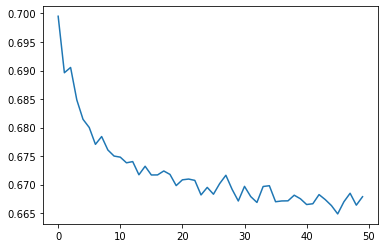

In [74]:
plt.plot(hist.history['MCRMSE'])

In [75]:
prediction = model.predict(x_train)

In [78]:
prediction_df = pd.DataFrame(prediction, columns=['pred_reactivity', 'pred_deg_pH10', 'pred_deg_Mg_pH10'])

In [79]:
data = pd.concat([train_data, prediction_df], axis=1)

In [87]:
tmp = data[data.id == 'id_001f94081']

In [88]:
tmp

,id,position,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,...,deg_error_Mg_50C,deg_50C,deg_error_50C,A_percentage,G_percentage,C_percentage,U_percentage,pred_reactivity,pred_deg_pH10,pred_deg_Mg_pH10
0,id_001f94081,1,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,...,0.1501,0.6382,0.2167,0.420561,0.17757,0.214953,0.186916,0.489834,1.928344,0.732594
1,id_001f94081,2,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,...,0.2750,3.4773,0.3475,0.420561,0.17757,0.214953,0.186916,1.497104,3.057792,2.230370
2,id_001f94081,3,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,...,0.0947,0.9988,0.1880,0.420561,0.17757,0.214953,0.186916,0.960204,0.919211,0.749636
3,id_001f94081,4,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,...,0.1866,1.3228,0.2124,0.420561,0.17757,0.214953,0.186916,0.857457,0.847866,0.710504
4,id_001f94081,5,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,...,0.1369,0.7877,0.1703,0.420561,0.17757,0.214953,0.186916,0.755574,0.809154,0.699081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,id_001f94081,64,C,),S,0.0693,0.0254,0.1277,0.0271,0.4140,...,0.0439,0.2391,0.0649,0.420561,0.17757,0.214953,0.186916,0.391928,0.581338,0.509725
64,id_001f94081,65,A,.,X,0.1398,0.0328,0.1608,0.0306,0.2238,...,0.0462,0.4234,0.0817,0.420561,0.17757,0.214953,0.186916,0.568768,0.749680,0.690729
65,id_001f94081,66,G,.,X,0.2937,0.0394,0.3336,0.0384,0.5142,...,0.0544,0.3287,0.0717,0.420561,0.17757,0.214953,0.186916,0.623752,0.787085,0.717339
66,id_001f94081,67,C,.,X,0.2362,0.0409,0.6491,0.0516,0.7681,...,0.0663,0.5301,0.0924,0.420561,0.17757,0.214953,0.186916,0.447262,0.651579,0.574155


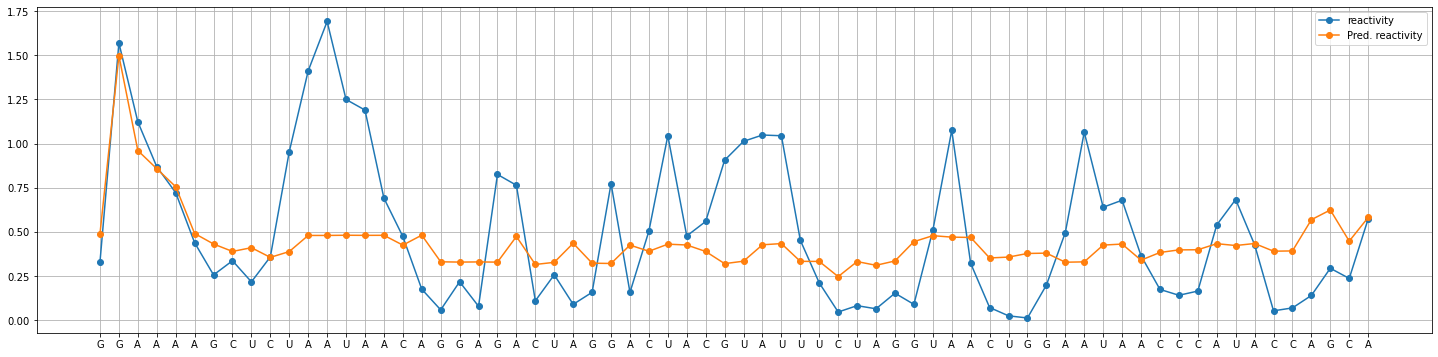

In [115]:
labels = tmp['sequence'].to_list()

fig, ax = plt.subplots(figsize=(25,6))
ax.plot( tmp['reactivity'], marker='o' )
ax.plot( tmp['pred_reactivity'], marker='o' )
plt.xticks(range(0, len(labels)),labels)
plt.legend( labels=["reactivity","Pred. reactivity"])
plt.grid()
plt.show()

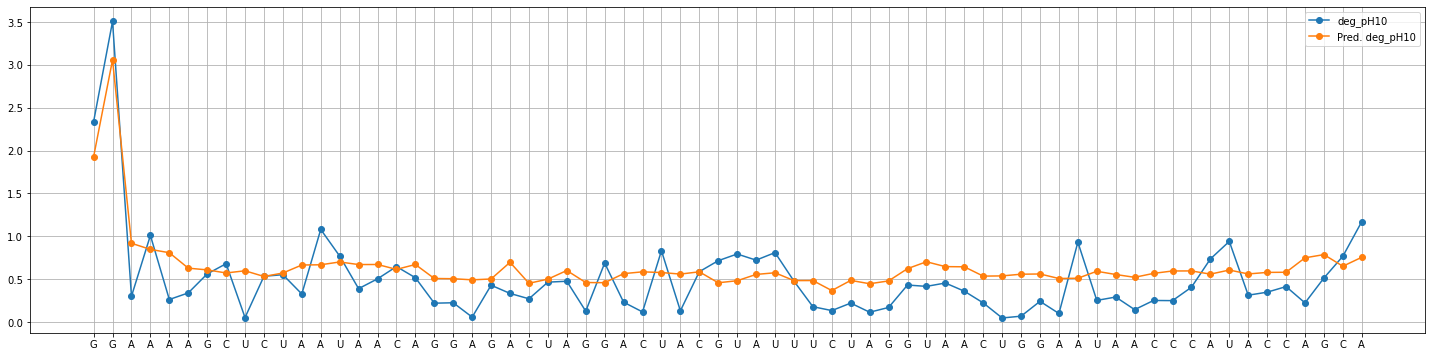

In [116]:
labels = tmp['sequence'].to_list()

fig, ax = plt.subplots(figsize=(25,6))
ax.plot( tmp['deg_pH10'], marker='o' )
ax.plot( tmp['pred_deg_pH10'], marker='o' )
plt.xticks(range(0, len(labels)),labels)
plt.legend( labels=["deg_pH10","Pred. deg_pH10"])
plt.grid()
plt.show()